In [1]:
from pearl.pearl_initial_formulation import *
from datastructures.graphutils import flatten_tree
from datastructures.api import (edges_no_param, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor)
from datastructures.graphutils import all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.transformations import transform_components
from copy import deepcopy
import openmdao.api as om

/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [29]:
run_optimal_structure = False

In [30]:
#nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

In [31]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [32]:
not_input = [r'\omega_0', 'E_{move}', 'A_{33}', 'B_M', 'K_G', 'I', 'E_{recharge}', 'm_{struct}']
not_output = ['D_f', 'D_d', 'D_s', 't_s', 't_f', 't_d', 'P_{comms}', 'R'] #R
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

In [33]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [34]:
tree_for_reformulation = flatten_tree(tree, 'opt')
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', mdf=True)
edges_minassign_noparam = edges_no_param(model, edges_minassign)

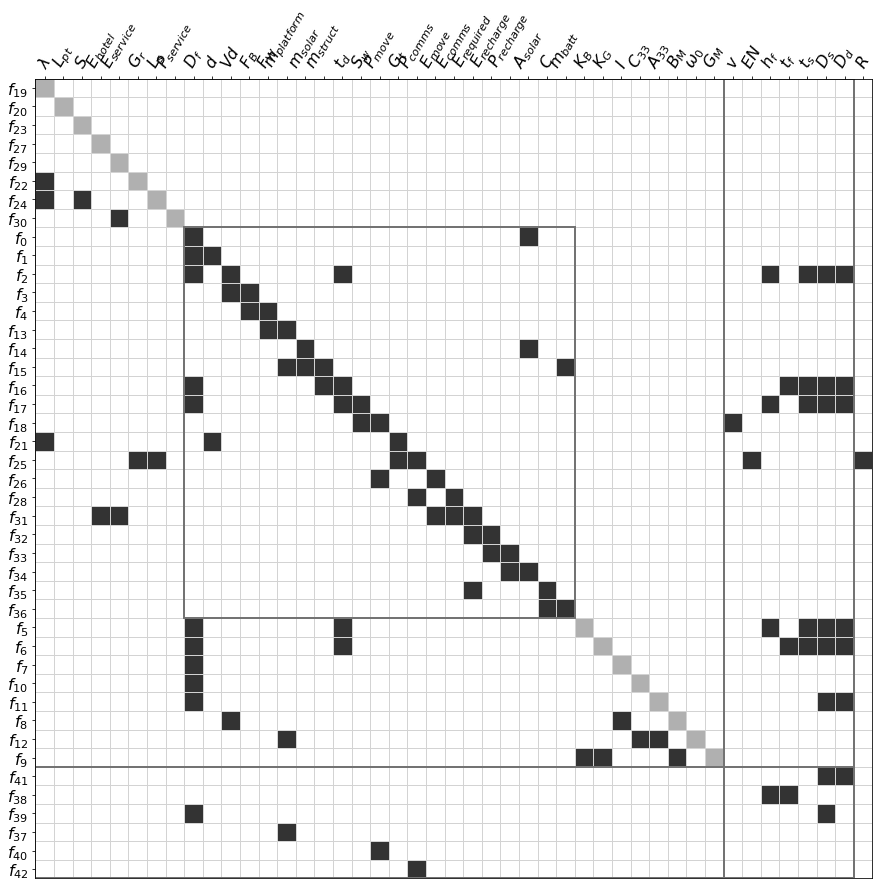

In [35]:
render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, figsize=(15,15));

In [36]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [37]:
from datastructures.execution import comp_id_lookup

In [38]:
comp_id_lookup(model.components+newcomps)[0]

[(('A_{solar}', '\\alpha'), 0, ('D_f',), '2.0*(1/(3.14159265358979 - 3.14159265358979*\\alpha))**0.5*Abs(A_{solar})**0.5'),
 (('D_f', 'A_{solar}', '\\alpha'), 0, (None,), 'D_f - 2.0*(1/(3.14159265358979 - 3.14159265358979*\\alpha))**0.5*Abs(A_{solar})**0.5')]

In [39]:
# comp_id_lookup(model.components+newcomps)[0][1].evaldict({'D_f':1.98482595, '\\alpha':0.2})

In [40]:
#newcomps[-1].evaldict({'m_{batt}': 31.47142857, 'm_{batt_zero}':5, '\\mu_{battery}':200, 'C':5.29428571})

## Add optimization problem to model

In [41]:
opt = addsolver(m, name="opt", idbyname=True)
addobj(opt, mtot) # for optimization make sure to add OPT in model
addineq(opt, hf-0.9*tf)
addineq(opt, hf-0.9*tf)
addineq(opt, Ds-0.9*Df)
addineq(opt, 0.1-P_move)
addineq(opt, Ds-0.9*Dd)
## Initial structure:
addineq(opt, 50-Pcomms)
solvefor_init = [v, EN, hf, tf, ts, Ds, Dd]
varoptions_init = {v:[0], EN:[0.1,100], hf:[0], tf:[0.1,10], ts:[0.1,10], 
             Ds:[0.1,10], Dd:[0.1,10]}
#varoptions_init.update({model.idmapping[elt]: [0] for elt in tree_minassign[2].keys()})
#varoptions_init.update({td: [0.1,10]})
addineq(opt, 0.1-td)
## Optimized structure:
solvefor_opt = [tf, ts, td, Ds, Dd, Df]
varoptions_opt = {tf:[0.1,10], ts:[0.1,10], td:[0.1,10], Ds:[0.1,10], Dd:[0.1,10], Df:[0.1,10]}

solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [42]:
#tree_minassign[2].keys()

In [43]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)

In [44]:
edges_ma_opt_nopar = edges_no_param(model, edges_ma_opt)

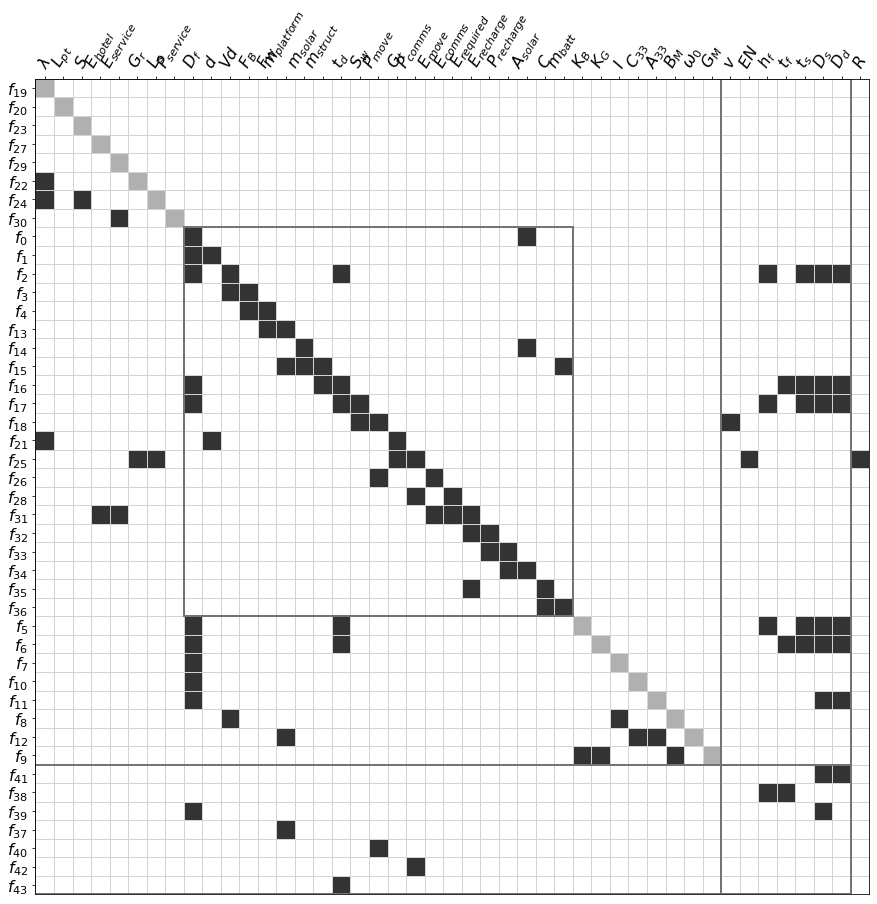

In [45]:
render_incidence(edges_ma_opt_nopar, tree_ma_opt, rawvarname=True, figsize=(15,15));

In [55]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [19]:
prob.set_val('P_comms', 50)

# Initial guesses

In [56]:
prob.set_val('t_f',0.15)
prob.set_val('t_s',0.2)
prob.set_val('t_d',0.2)
prob.set_val('D_f', 3.713)
prob.set_val('D_s', 0.1)
prob.set_val('D_d', 1.)

In [49]:
import json
with open('x0init.json', 'r') as f:
    x0 = json.loads(f.read())
for var,val in x0.items():
    prob.set_val(var,val)

In [57]:
prob.run_model()


==
s2
==
NL: NewtonSolver 'NL: Newton' on system 's2' failed to converge in 10 iterations.


In [58]:
prob.run_driver()


==
s2
==
NL: NewtonSolver 'NL: Newton' on system 's2' failed to converge in 10 iterations.

==
s2
==
NL: NewtonSolver 'NL: Newton' on system 's2' failed to converge in 10 iterations.

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: New

False

In [28]:
prob.get_val('v')

array([0.8292487])

In [23]:
ins_init = ['D_f', 'd', 'Vd', 'F_B', 'F_W', 'm_platform', 'm_solar', 'm_struct', 't_d', 'S_w', 'P_move', 'G_t', 'P_comms', 'E_move', 'E_comms', 'E_required', 'E_recharge', 'P_recharge', 'A_solar', 'C', 'm_batt', 'v', 'EN', 'h_f', 't_f', 't_s', 'D_s', 'D_d']
x0  = {elt:prob.get_val(elt)[0] for elt in ins_init}

In [24]:
x0

{'D_f': 1.984825945852736,
 'd': 0.39696518917054724,
 'Vd': 0.5718096039463969,
 'F_B': 5741.835286981408,
 'F_W': 5741.835286981408,
 'm_platform': 585.3043105995318,
 'm_solar': 24.752822367920658,
 'm_struct': 429.08005966026553,
 't_d': 0.09999999000004137,
 'S_w': 9.77023399145849,
 'P_move': 0.09999999013936355,
 'G_t': 46.00130320479174,
 'P_comms': 50.0,
 'E_move': 9.999999013936354e-05,
 'E_comms': 50.0,
 'E_required': 3.1500999999901396,
 'E_recharge': 3.1500999999901396,
 'P_recharge': 262.5083333325116,
 'A_solar': 2.475282236792066,
 'C': 5.294285714269142,
 'm_batt': 31.471428571345708,
 'v': 0.02466145284720914,
 'EN': 26.19527980944559,
 'h_f': 0.09000000100001639,
 't_f': 0.09999999000001968,
 't_s': 10.000000099995864,
 'D_s': 0.19207752158303032,
 'D_d': 0.21341945731452228}

In [23]:
import json
with open('x0init.json', 'w') as f:
    f.write(json.dumps(x0))

In [59]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name  val           size  lower  upper  
----  ------------  ----  -----  ----- 
v     [0.02466145]  1     0.0    1e+30  
EN    [26.1952798]  1     0.1    100.0  
h_f   [0.09]        1     0.0    1e+30  
t_f   [0.09999999]  1     0.1    10.0   
t_s   [10.0000001]  1     0.1    10.0   
D_s   [0.19207752]  1     0.1    10.0   
D_d   [0.21341946]  1     0.1    10.0   

-----------
Constraints
-----------
name   val               size  lower   upper  equals  
-----  ----------------  ----  ------  -----  ------ 
neq41  [9.99996028e-09]  1     -1e+30  0.0    None    
neq38  [9.99999869e-09]  1     -1e+30  0.0    None    
neq39  [-1.59426583]     1     -1e+30  0.0    None    
neq40  [9.86075652e-09]  1     -1e+30  0.0    None    
neq42  [9.86056392e-09]  1     -1e+30  0.0    None    
neq43  [9.99995907e-09]  1     -1e+30  0.0    None    

----------
Objectives
----------
name   val            size  
-----  -------------  ---- 
obj37  [585.30